In this notebook I try to calculate marine heatwaves using the code in Eric Oliver's marineHeatwaves repository.

The code works but it works on only a single pixel at a time. I wrote a loop to calculate many pixels but it quickly becomes slow. I wasn't able to parallelize the loop with dask.

In [1]:
from datetime import datetime 

import fsspec
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import marineHeatWaves as mhw

## Load & Subset MUR

In [2]:
# Block: LOAD ZARR (no task activity)
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

mur_full = xr.open_zarr(ikey, consolidated=True)
mur = mur_full['analysed_sst']

In [3]:
# Block: SUBSET
# 4 chunk subset, ~110 MB total
mur_subset = mur.sel(lat=slice(32, 32.4), lon=slice(123.0, 123.2))

In [22]:
mur_subset

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 40, lon: 21)>
dask.array<getitem, shape=(6443, 40, 21), dtype=float32, chunksize=(6443, 39, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 32.01 32.02 32.03 ... 32.36 32.37 32.38 32.39
  * lon      (lon) float32 123.0 123.0 123.0 123.0 ... 123.2 123.2 123.2 123.2
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

## Oliver MHW code

### Preprocessing

In [4]:
# Format time values
time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') for time in mur_subset.time.values]
time_ordinal = np.array([time.toordinal() for time in time_dt_list])


In [5]:
# Extract sst as a numpy array
sst_np = mur_subset.values

### Calculating an individual pixel

Example of how to use this code on a single point.

In [6]:
mhws, clim = mhw.detect(time_ordinal, sst_np[:, 2, 2])

## Calculating a block of data

In [18]:
# Get number of pixels in each dimension
size_t, size_lat, size_lon = sst_np.shape

# Create empty arrays to hold the outputs
full_climatology = np.empty(sst_np.shape)
full_threshold = np.empty(sst_np.shape)

# loop through each pixel in the sst array
for idx_lat in range(size_lat):
    for idx_lon in range(size_lon):
        # Calculate MHW stats for that pixel
        mhws, point_clim = mhw.detect(time_ordinal, sst_np[:, idx_lat, idx_lon])
        # Add the climatology and threshold to the output arrays
        full_climatology[:, idx_lat, idx_lon] = point_clim['seas']
        full_threshold[:, idx_lat, idx_lon] = point_clim['thresh']


In [23]:
full_climatology.shape

(6443, 40, 21)

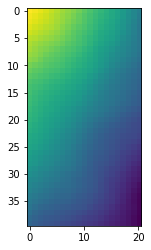

In [19]:
# A very rudimentary visual
plt.imshow(full_threshold[0])

### Some loose timing
A) `mur.sel(lat=slice(32, 32.4), lon=slice(123.0, 123.2))`
* `.values` extract ~20 seconds
* loop took ~90 seconds

B) `mur.sel(lat=slice(32, 33), lon=slice(123.0, 124))` (33,187,893 pixels (`.size`))
* `.values` extract ~4 seconds ??? (shorter than previous?)
* loop took ~9.5 minutes (accidently did this on with Dask on, but I don't think that makes a difference)

C) `mur.sel(lat=slice(32, 33), lon=slice(123.0, 124))` (65,725,043 pixels (`.size`))
* `.values` extract ~4 seconds
* loop took ~19 minutes
* Notes: memory seems to stay at 0.2%; CPU does max out (100% of a worker)

D) Estimate for 3.5*2.25 degrees:
`mur.sel(lat=slice(32, 35.5), lon=slice(123.0, 125.25))` (511,097,418 (`.size`))
* `.values` extract 32 seconds (it did fit into memory :tada:)
* estimate for loop: 8 times longer than C -- 160 minutes

## Trying the loop with dask delayed

I could not get this to work. Best guess: I think `full_climatology` and `full_threshold` will also need to be dask arrays in order to build the task graph prior to computation, but I get the error:
```
ValueError: Boolean index assignment in Dask expects equally shaped arrays.
Example: da1[da2] = da3 where da1.shape == (4,), da2.shape == (4,) and da3.shape == (4,).
```

In [10]:
import dask
from dask.distributed import Client

from dask import delayed
import dask.array as da

In [8]:
dask.config.set(temporary_directory='/data/pacific/rwegener/')

client = Client(memory_limit='216GB')
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [14]:
# Get number of pixels in each dimension
size_t, size_lat, size_lon = sst_np.shape

# Create empty arrays to hold the outputs
full_climatology = np.empty(sst_np.shape)
full_threshold = np.empty(sst_np.shape)

# Dask-ify inputs
time_ordinal_da = da.from_array(time_ordinal)

# loop through each pixel in the sst array
for idx_lat in range(size_lat):
    for idx_lon in range(size_lon):
        # Calculate MHW stats for that pixel
        sst_da = da.from_array(sst_np[:, idx_lat, idx_lon])
        mhws, point_clim = delayed(mhw.detect(time_ordinal_da, sst_da))
        # Add the climatology and threshold to the output arrays
        full_climatology[:, idx_lat, idx_lon] = point_clim['seas']
        full_threshold[:, idx_lat, idx_lon] = point_clim['thresh']

ValueError: Boolean index assignment in Dask expects equally shaped arrays.
Example: da1[da2] = da3 where da1.shape == (4,), da2.shape == (4,) and da3.shape == (4,).

In [27]:
client.close()